# IMDB with pytorch but using keras data

I just realized that I was using a mere 2000 records and the keras book and examples were using a much larger 25000 (train and also test) data set. So I'm going to use keras to pull that data and but process it using PyTorch.

In [2]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [4]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load IMDb from keras

In [5]:
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
from keras import preprocessing

Using TensorFlow backend.


In [6]:
max_features = vocab_size = 10_000
maxlen = ndocprefix = 20
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

17465344/17464789 [==============================] - 2s 0us/step


In [7]:
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
X_train = torch.tensor(X_train).long().to(device)
X_test = torch.tensor(X_test).long().to(device)
y_train = torch.tensor(y_train).float().reshape(-1,1).to(device)
y_test = torch.tensor(y_test).float().reshape(-1,1).to(device)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 0.20)

## Train

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [11]:
class IMBD(TensorDataset):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.X = X # track with easy to use fields
        self.y = y

In [18]:
from sklearn.metrics import accuracy_score
def train(model, train_data, valid_data,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        loss = 0
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss += loss_fn(y_prob, batch_y) 

        # Q: compute gradient only after a whole batch? Here i'm doing per instance (pure SGD)
        # Yep, make it "loss +=" above and then this works much better shift out of batch loop
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()
        
        with torch.no_grad():
            loss        = loss_fn(model(train_data.X), train_data.y)
            loss_valid  = loss_fn(model(valid_data.X), valid_data.y)
            accur_train = accuracy_score(torch.round(model(train_data.X).cpu()), train_data.y.cpu())
            accur_valid = accuracy_score(torch.round(model(valid_data.X).cpu()), valid_data.y.cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

In [19]:
class Sentiment(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.final = nn.Linear(ndocprefix*nfactors,1)
        
    def forward(self, x):
#         print(x.device)       # cuda:0 or cpu
#         print(x.shape)      # [1600, 20]
        output = self.embedding(x)
#         print(output.shape) # [1600, 20, 8] = (samples, num word features, embedding dim)
        # must cat the 20 64-vectors together
        output = output.view((x.shape[0], -1))
#         print(output.shape) # [1600, 160]
        output = self.final(output)
#         print(output.shape) # [1600, 1]
        return torch.sigmoid(output)

20000 training and 5000 test records
Epoch   0 log loss   0.829,   0.811   accuracy 0.494, 0.509
Epoch   3 log loss   0.620,   0.656   accuracy 0.653, 0.610
Epoch   6 log loss   0.543,   0.633   accuracy 0.724, 0.646
Epoch   9 log loss   0.447,   0.600   accuracy 0.794, 0.693
Epoch  12 log loss   0.392,   0.608   accuracy 0.825, 0.703
Epoch  15 log loss   0.348,   0.617   accuracy 0.852, 0.714
Epoch  18 log loss   0.303,   0.632   accuracy 0.875, 0.722
Epoch  21 log loss   0.268,   0.655   accuracy 0.894, 0.722
Epoch  24 log loss   0.241,   0.688   accuracy 0.908, 0.723
Epoch  27 log loss   0.218,   0.722   accuracy 0.919, 0.719


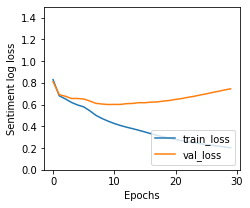

In [43]:
nfactors = 6
model = Sentiment(vocab_size, nfactors).to(device)

print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=30,
                       learning_rate=.013,
                       weight_decay=0.00001,
                       batch_size=32,
                       print_every=3)

plot_history(history, yrange=(0,1.5))

Whew! Ok,Getting the same rough accuracy that those guys do from the book. They said about 76% accurate.

## Add more layers and dropout

In [49]:
import torch
import torch.nn as nn

layer1 = 32
layer2 = 32
class SentimentRegularized(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(SentimentRegularized, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.layers = nn.Sequential(
            nn.Linear(ndocprefix*nfactors,layer1), # 300 neurons
#            nn.BatchNorm1d(layer1),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=layer1, out_features=layer2),
#            nn.BatchNorm1d(layer2),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(layer2,1)
        )
        
    def forward(self, x):
        output = self.embedding(x)
        output = output.view((x.shape[0], -1))
        output = self.layers(output)
        return torch.sigmoid(output)

20000 training and 5000 test records
Epoch   0 log loss   0.522,   0.561   accuracy 0.748, 0.704
Epoch   1 log loss   0.409,   0.516   accuracy 0.817, 0.744
Epoch   2 log loss   0.358,   0.527   accuracy 0.849, 0.749
Epoch   3 log loss   0.329,   0.573   accuracy 0.862, 0.749
Epoch   4 log loss   0.291,   0.639   accuracy 0.880, 0.742


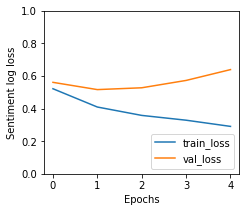

In [56]:
nfactors = 4
model = SentimentRegularized(vocab_size, nfactors).to(device)

print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=5,
                       learning_rate=.01,
                       weight_decay=0.000001,
                       batch_size=32,
                       print_every=1)

plot_history(history, yrange=(0,1.0))